In [1]:
import detection as eddy
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm
from tqdm import tqdm
import ast

# Set default font size to match LaTeX document
plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 12 # Figure title size
})

In [2]:
# Enable/disable computation of different domains
config_parent_domain = False
config_child_domain = False

In [3]:
# Import data #######################################################################################################################
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(70,75)).sel(X=slice(-22,2))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var_eddies.nc')

df_OW = df['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = df['Eta']

od = ospy.OceanDataset(df)
od = od.compute.horizontal_velocity_magnitude()

df_hor_vel = od['hor_vel']
# Delete no longer used variables which uses memory
del od, df

Computing magnitude of horizontal velocity


In [4]:
# Inner domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1])).sel(Z=-1)
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Outer domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1)).sel(Z=-1)

In [5]:
# Resample data
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

# Define time extent
time = ['2018-06-01T00:00:00.000000000','2018-06-05T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))
hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(70,75)).sel(X=slice(-22,2)).sel(time=slice(time[0],time[1]))
FWC = FWC.resample(time='D').mean(dim='time')

eta = eta.where(depth > 0, np.nan)
OW = OW.where(depth > 0, np.nan)
# hor_vel = hor_vel.where(depth > 0, np.nan)


# Eddy centerpoints (Child domain)

# Try updated Eddy center detection

In [6]:
import EddyDetectionV2 as testeddy # Works much better

In [7]:
# Computes or loads eddy centerpoints
run = config_child_domain

if run:
    eddyLocation = []
    T = len(eta)
    pbar = tqdm(total=T, desc="Running eddy centerpoint algorythm")
    for i in range(len(eta)):
        eddyLocation.append(testeddy.eddyDetection(eta_center[i],OW_center[i]))
        pbar.update(1)
    pbar.close()
    with open("eddyCenterpoints_test_v2.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_test_v2.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Loading previously saved eddy centerpoints###


In [8]:
print(len(eddyLocation[0][0]))

56


# Test new inner eddy method

In [9]:
run = config_parent_domain
if run:
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    T = len(eddyLocation)
    pbar = tqdm(total=T, desc="Running algorythm")
    for time in range(len(eddyLocation)):
        eddies[time] = testeddy.Full_eddy_region_v1(eddyLocation[time][0],eta=eta[time],hor_vel=hor_vel[time],warm=True,cold=False,test_calib=False,eddiesData=eddies[time])
        eddies[time] = testeddy.Full_eddy_region_v1(eddyLocation[time][1],eta=eta[time],hor_vel=hor_vel[time],warm=False,cold=True,test_calib=False,eddiesData=eddies[time])
        pbar.update(1)

    eddies = eddies.where(eddies != 0, np.nan)
    eddies.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/EddiesTest_v3.nc')
    pbar.close()
else:
    eddies = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/EddiesTest_v3.nc')
    eddies = eddies['EddyDetection']


In [10]:
eddies = eddies.where(eddies != 0, np.nan)

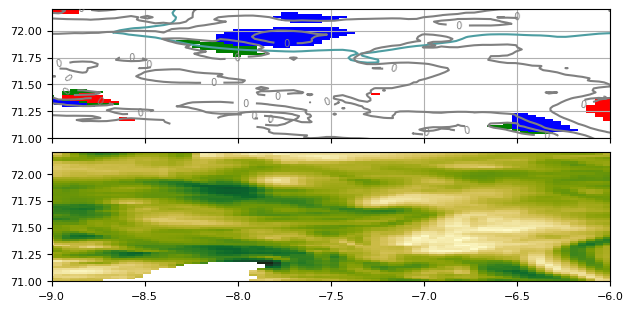

In [11]:
fig, (ax,ax2) = plt.subplots(2,1,
    figsize=(6.2217,3), sharey=True,sharex=True, layout='constrained'
)

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

ax.pcolormesh(eddies.X,eddies.Y,eddies[0],cmap=cmap,norm=norm)
ax.set_xlim(-9,-6)
ax.set_ylim(71,72.2)

ax.contour(eta.X,eta.Y,eta[0],cmap=cmo.deep)
cntr = ax.contour(hor_vel.X,hor_vel.Y,hor_vel[0],colors='grey')
ax.clabel(cntr, fmt="%2.0f", use_clabeltext=True,fontsize=7)

ax.grid()

ax2.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],cmap=cmo.speed,vmin=0,vmax=0.5)

fig.savefig(r'/nird/home/ekv036/MSc/Fig/EddyTestCalib',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

Generating Frames: 11it [00:24,  2.25s/it]                      


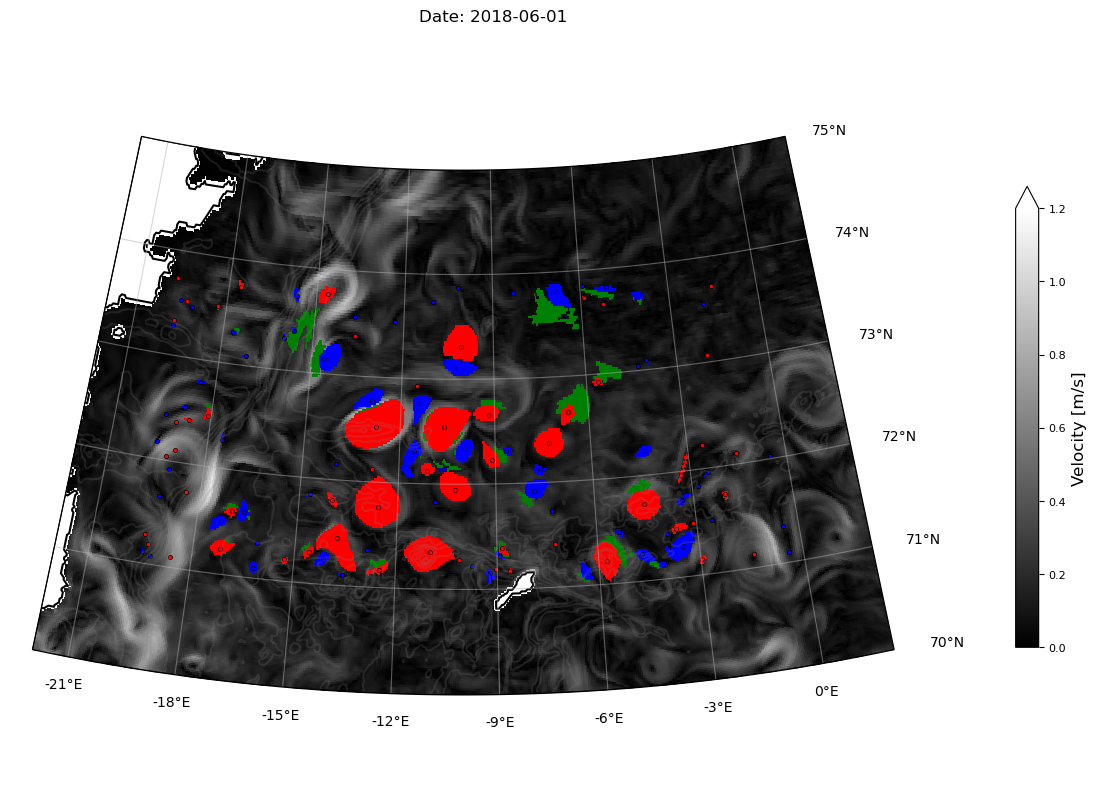

In [12]:
from matplotlib.animation import FuncAnimation, FFMpegFileWriter

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22+10, 2+10, 70, 75]

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh without normalization
pcm1 = axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
axs.pcolormesh(eddies.X, eddies.Y, eddies[0], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())

for data in eddyLocation[0][0]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
for data in eddyLocation[0][1]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
    
# Add land contour
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='max')
cbar.set_label('Velocity [m/s]', fontsize=12)


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
axs.add_patch(patch)


# Set the boundary using the transformed path
axs.set_boundary(patch.get_path(), transform=axs.transData)

# Add gridlines without labels
gl = axs.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(-21, 0+1, 3)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


T = len(eddies.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs.clear()
    fig.suptitle(f'Date: {str(eddies.time.values[frame])[0:10]}')
    axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[frame],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
    axs.pcolormesh(eddies.X, eddies.Y, eddies[frame], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][0]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][1]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
    
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
    axs.add_patch(patch)


    # Set the boundary using the transformed path
    axs.set_boundary(patch.get_path(), transform=axs.transData)

    # Add gridlines without labels
    gl = axs.gridlines(draw_labels=False,alpha=0.5)

    # Manually add the labels for the bottom and right sides
    xticks = np.arange(-21, 0+1, 3)  # Adjust the range and step as needed
    yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

    # Add bottom labels
    for xtick in xticks:
        axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

    # Add right labels
    for ytick in yticks:
        axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')


    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=400)
ani.save(r'/nird/home/ekv036/MSc/Animations/Eddies_v3.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()

In [13]:
display(eddies.max())

<xarray.DataArray 'EddyDetection' ()>
array(4.)

Generating Frames: 11it [00:24,  2.19s/it]                      


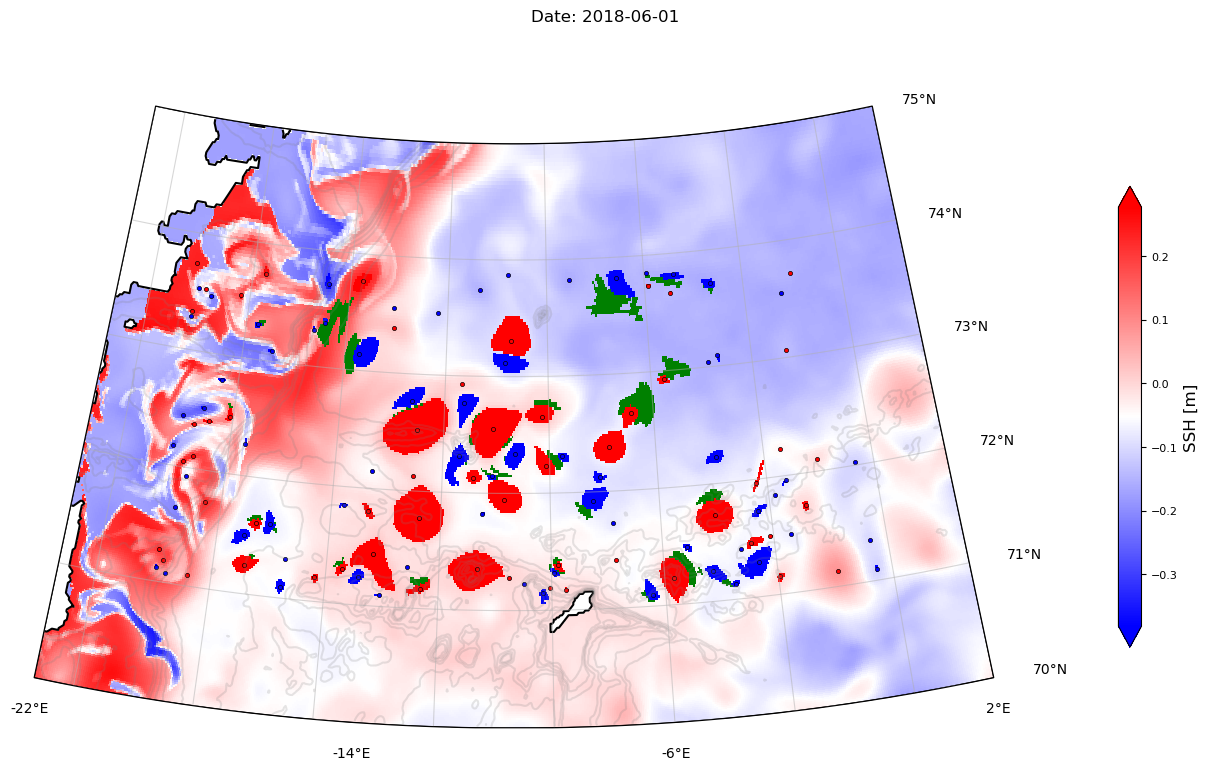

In [14]:
from matplotlib.animation import FuncAnimation, FFMpegFileWriter

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22+10, 2+10, 70, 75]

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh without normalization
pcm1 = axs.pcolormesh(eta.X,eta.Y,eta[0],vmin=eta.min(),vmax=eta.max(),cmap='bwr',transform=ccrs.PlateCarree())
axs.pcolormesh(eddies.X, eddies.Y, eddies[0], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
for data in eddyLocation[0][0]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
for data in eddyLocation[0][1]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
# Add land contour
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='both')
cbar.set_label('SSH [m]', fontsize=12)


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
axs.add_patch(patch)


# Set the boundary using the transformed path
axs.set_boundary(patch.get_path(), transform=axs.transData)

# Add gridlines without labels
gl = axs.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


T = len(eddies.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs.clear()
    fig.suptitle(f'Date: {str(eddies.time.values[frame])[0:10]}')
    axs.pcolormesh(eta.X,eta.Y,eta[frame],vmin=eta.min(),vmax=eta.max(),cmap='bwr',transform=ccrs.PlateCarree())
    axs.pcolormesh(eddies.X, eddies.Y, eddies[frame], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][0]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][1]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
    
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
    axs.add_patch(patch)


    # Set the boundary using the transformed path
    axs.set_boundary(patch.get_path(), transform=axs.transData)

    # Add gridlines without labels
    gl = axs.gridlines(draw_labels=False,alpha=0.5)

    # Manually add the labels for the bottom and right sides
    xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
    yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

    # Add bottom labels
    for xtick in xticks:
        axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

    # Add right labels
    for ytick in yticks:
        axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')


    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=400)
ani.save(r'/nird/home/ekv036/MSc/Animations/Eddies_v3_eta.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()

# FWC in the domain

In [15]:
display(FWC)

<xarray.DataArray '__xarray_dataarray_variable__' (time: 5, Y: 231, X: 510)>
array([[[ 6.83534979e+00,  6.64649628e+00,  6.49114653e+00, ...,
         -1.09672910e-02, -1.09436672e-02, -1.09123862e-02],
        [ 6.82627437e+00,  6.61107452e+00,  6.43898398e+00, ...,
         -1.09321959e-02, -1.09001430e-02, -1.08686384e-02],
        [ 6.80564655e+00,  6.59833046e+00,  6.39293350e+00, ...,
         -1.09107612e-02, -1.08690530e-02, -1.08372652e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.25738263e-03, -2.72742514e-03, -2.27622282e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.40570167e-03, -1.82402918e-03, -1.48500277e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.72728068e-03, -1.34491834e-03, -1.19925534e-03]],

       [[ 6.74923715e+00,  6.55669487e+00,  6.37513778e+00, ...,
         -1.12061659e-02, -1.11940846e-02, -1.12267170e-02],
        [ 6.72584829e+00,  6.52517043e+00,  6.34027417e+00, ...,
         -1.12975962e-02, -1.12370659e-02, -1.12236226e-02],
        [ 6.69638880e+00,  6.51049085e+00,  6.31324176e+00, ...,
         -1.13791936e-02, -1.12915378e-02, -1.12477453e-02],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.87184993e-03, -1.77294182e-03, -1.74640951e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.41651751e-03, -1.37106253e-03, -1.42077134e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.42465794e-03, -1.36066440e-03, -1.35437138e-03]],

       [[ 6.32743744e+00,  6.00646186e+00,  5.79585379e+00, ...,
         -1.24615582e-02, -1.25276302e-02, -1.26083216e-02],
        [ 6.33400116e+00,  5.98453049e+00,  5.77267820e+00, ...,
         -1.18839503e-02, -1.19890957e-02, -1.21293987e-02],
        [ 6.35282610e+00,  6.00442044e+00,  5.77925230e+00, ...,
         -1.13442852e-02, -1.14204324e-02, -1.15434864e-02],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.80006059e-03, -1.75014196e-03, -1.74526915e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.39015484e-03, -1.38705414e-03, -1.46102790e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.39257858e-03, -1.38182916e-03, -1.38465454e-03]]])
Coordinates:
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2018-06-01 2018-06-02 ... 2018-06-05

Generating Frames: 11it [00:29,  2.68s/it]                      


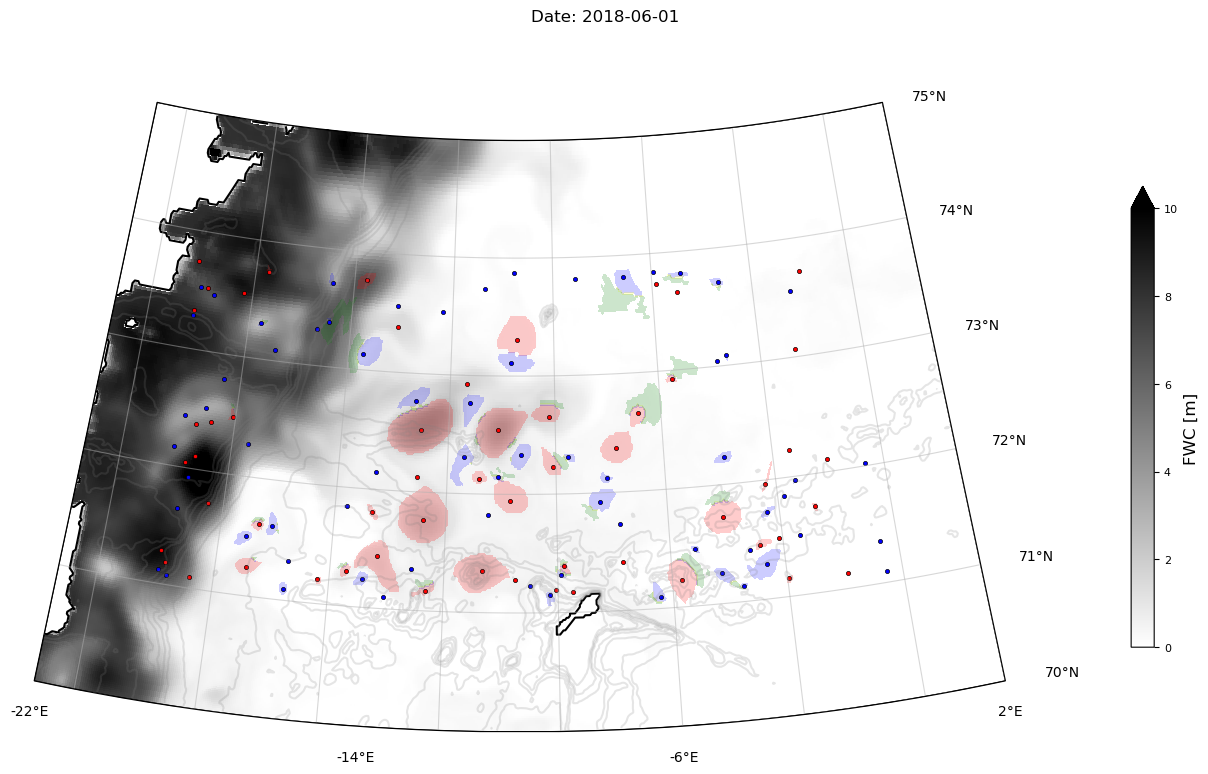

In [16]:
# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-22+10, 2+10, 70, 75]

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh without normalization
pcm1 = axs.pcolormesh(FWC.X,FWC.Y,FWC[0],vmin=0,vmax=10,cmap='binary',transform=ccrs.PlateCarree())
axs.contourf(eddies.X, eddies.Y, eddies[0],levels=bounds, cmap=cmap,alpha=0.2, transform=ccrs.PlateCarree())
for data in eddyLocation[0][0]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
for data in eddyLocation[0][1]:
    axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
# Add land contour
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='max')
cbar.set_label('FWC [m]', fontsize=12)


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
axs.add_patch(patch)


# Set the boundary using the transformed path
axs.set_boundary(patch.get_path(), transform=axs.transData)

# Add gridlines without labels
gl = axs.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


T = len(eddies.time)
pbar = tqdm(total=T, desc="Generating Frames")

def update_plot(frame):
    axs.clear()
    fig.suptitle(f'Date: {str(eddies.time.values[frame])[0:10]}')
    axs.pcolormesh(FWC.X,FWC.Y,FWC[frame],vmin=0,vmax=10,cmap='binary',transform=ccrs.PlateCarree())
    axs.contourf(eddies.X, eddies.Y, eddies[frame],levels=bounds, cmap=cmap,alpha=0.2, transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][0]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
    for data in eddyLocation[frame][1]:
        axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
    
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
    axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())

    
    # Create a custom path for the extent in PlateCarree projection
    num_points = 100
    bottom_lons = np.linspace(extent[0], extent[1], num_points)
    top_lons = np.linspace(extent[1], extent[0], num_points)
    bottom_lats = np.full_like(bottom_lons, extent[2])
    top_lats = np.full_like(top_lons, extent[3])

    # Combine the vertices
    verts = np.vstack([
        np.column_stack([bottom_lons, bottom_lats]),
        np.column_stack([top_lons, top_lats])
    ])

    # Transform the vertices to the NorthPolarStereo projection
    proj = ccrs.NorthPolarStereo()
    verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
    verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

    # Create the path
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
    path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
    patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
    axs.add_patch(patch)


    # Set the boundary using the transformed path
    axs.set_boundary(patch.get_path(), transform=axs.transData)

    # Add gridlines without labels
    gl = axs.gridlines(draw_labels=False,alpha=0.5)

    # Manually add the labels for the bottom and right sides
    xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 8)  # Adjust the range and step as needed
    yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

    # Add bottom labels
    for xtick in xticks:
        axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                fontsize=10, ha='center', va='top')

    # Add right labels
    for ytick in yticks:
        axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                fontsize=10, ha='left', va='center')


    pbar.update(1)

ani = FuncAnimation(fig, update_plot, frames=T, interval=400)
ani.save(r'/nird/home/ekv036/MSc/Animations/Eddies_v3_FWC.gif', writer='pillow', progress_callback=lambda i, n: pbar.update(1))
pbar.close()

In [17]:
test_df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var_eddies.nc')

In [18]:
display(test_df)

<xarray.Dataset>
Dimensions:      (Z: 1, Zp1: 2, Zu: 1, Zl: 1, X: 765, Y: 628, Xp1: 766,
                  Yp1: 629, time: 365, time_midp: 364)
Coordinates: (12/18)
  * Z            (Z) float64 -1.0
  * Zp1          (Zp1) float64 0.0 -2.0
  * Zu           (Zu) float64 -2.0
  * Zl           (Zl) float64 0.0
  * X            (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.72 11.82 11.92
  * Y            (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    ...           ...
  * time         (time) datetime64[ns] 2017-09-01 2017-09-02 ... 2018-08-31
    YU           (Y, Xp1) float64 ...
    XU           (Y, Xp1) float64 ...
    YV           (Yp1, X) float64 ...
    XV           (Yp1, X) float64 ...
  * time_midp    (time_midp) datetime64[ns] 2017-09-01T12:00:00 ... 2018-08-3...
Data variables:
    U            (time, Z, Y, Xp1) float64 ...
    V            (time, Z, Yp1, X) float64 ...
    Eta          (time, Y, X) float64 ...
    Okubo_Weiss  (time, Z, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

Generating Frames: 100%|██████████| 5/5 [00:25<00:00,  4.71s/it]

IndexError: index 5 is out of bounds for axis 0 with size 5

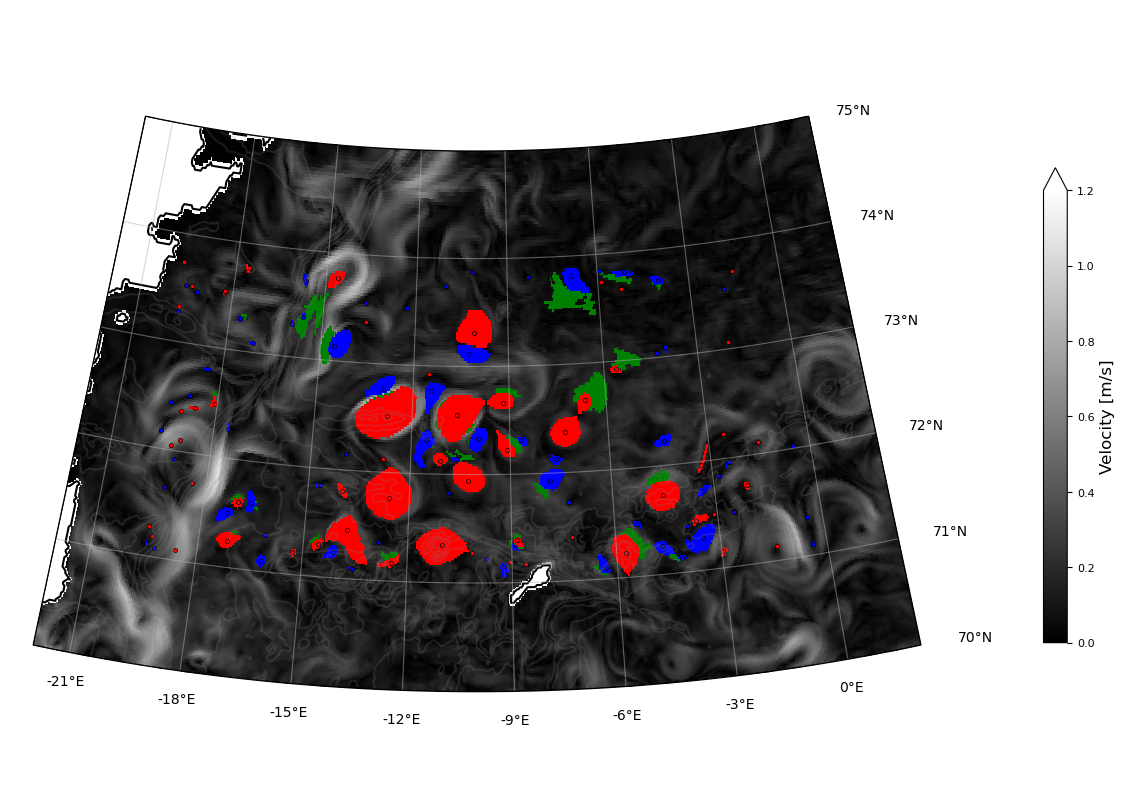

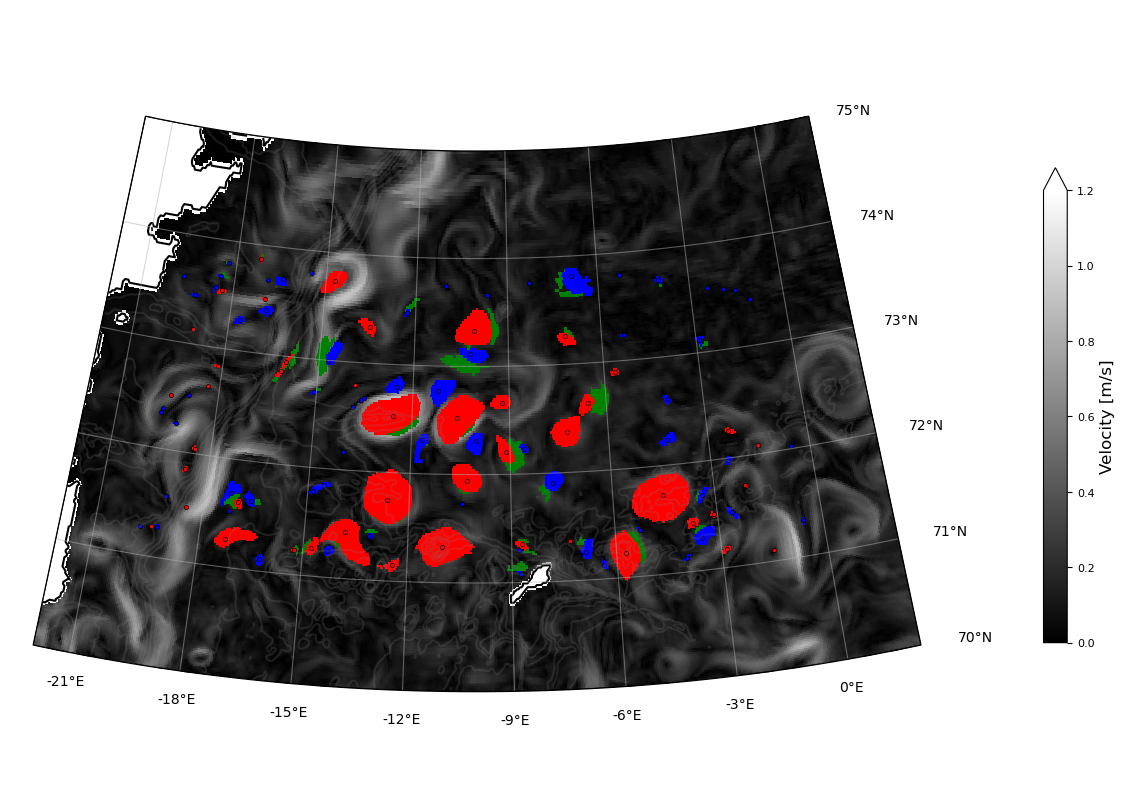

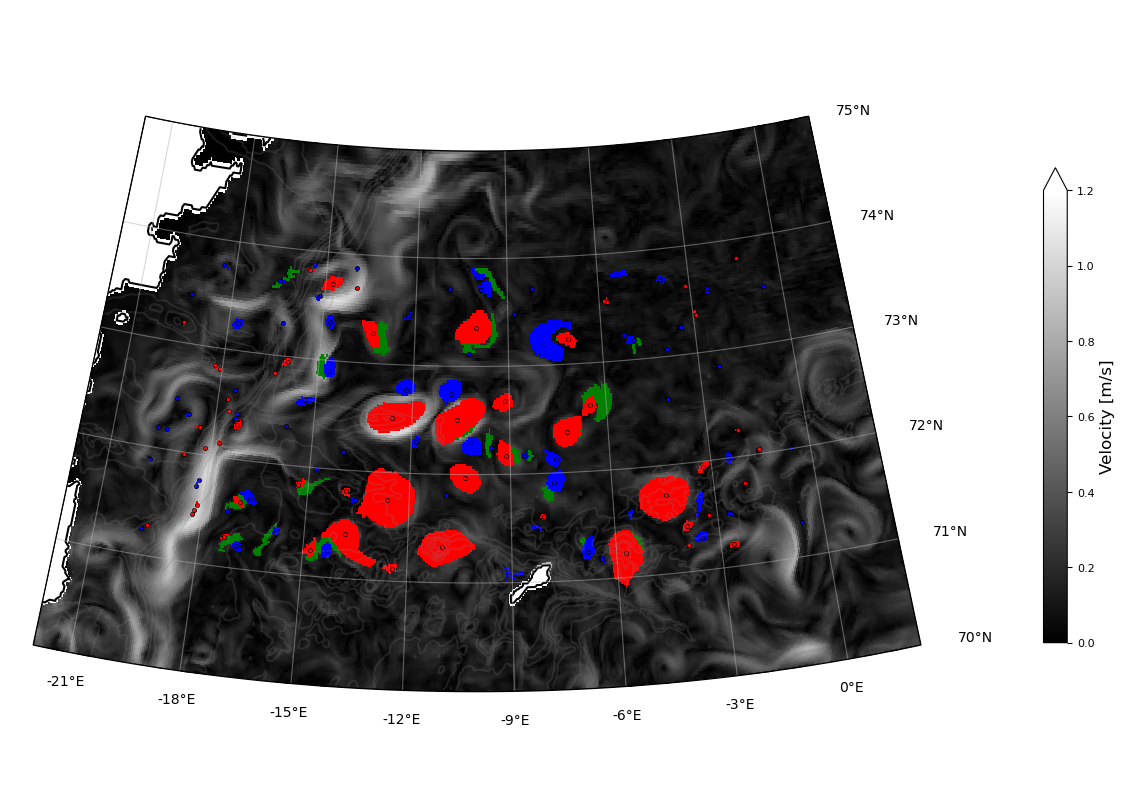

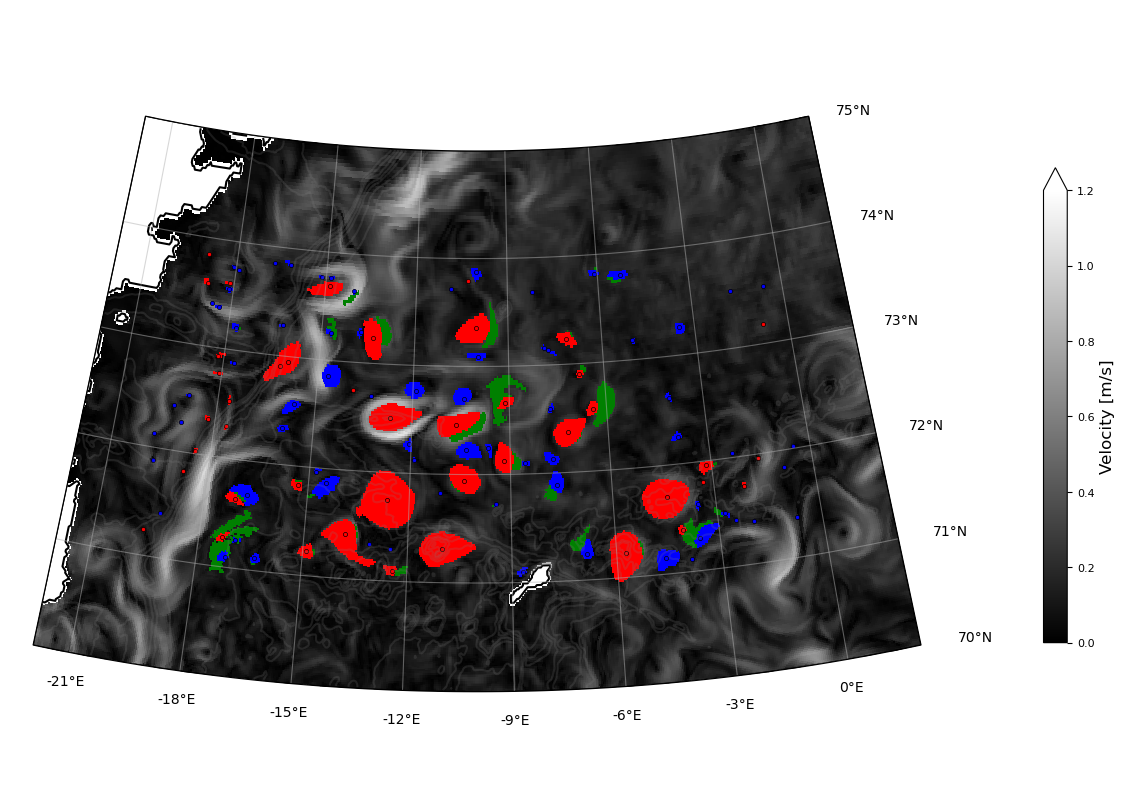

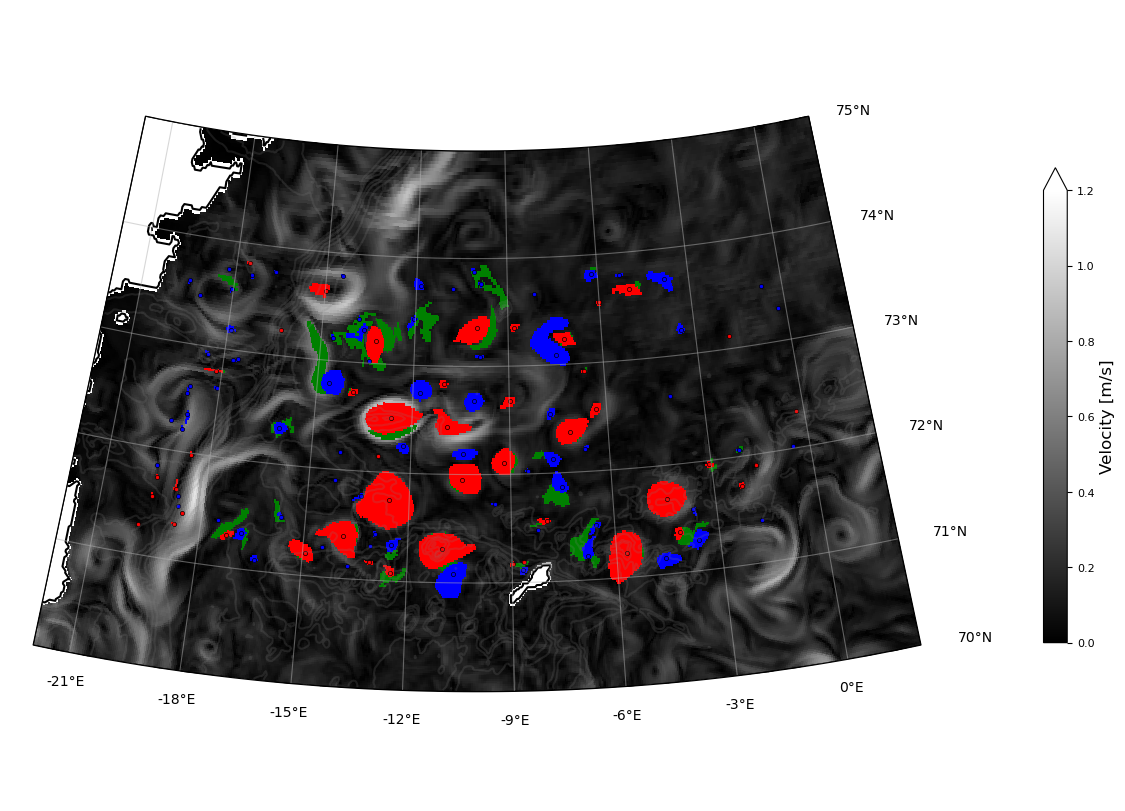

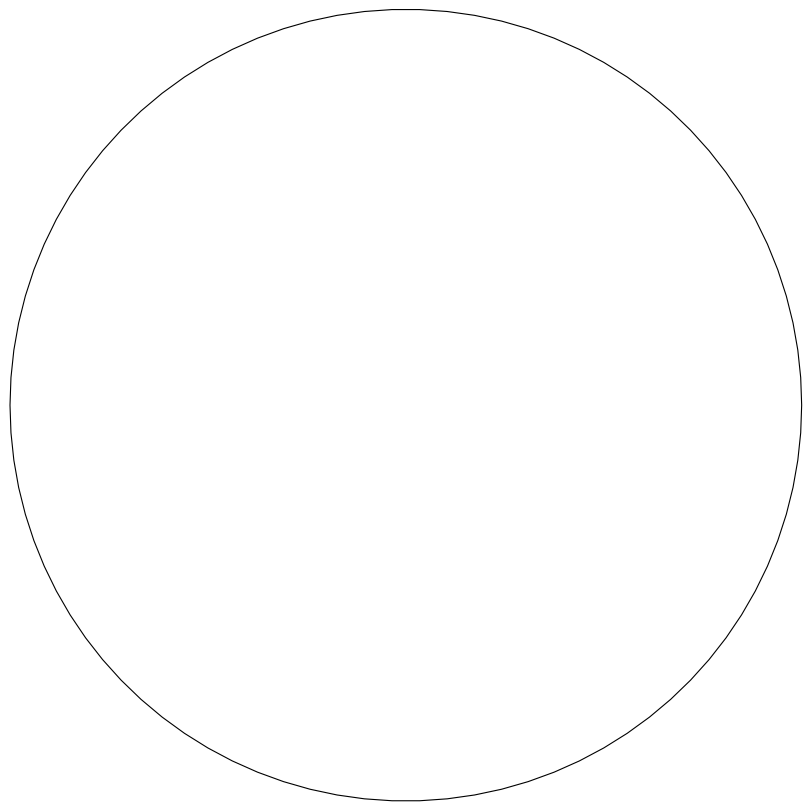

In [19]:
# Testing single frame
run = True
if run:
    T = len(eddies.time)
    pbar = tqdm(total=T, desc="Generating Frames")
    for frame in range(len(eddyLocation)):
        # Create a figure and axis with Cartopy using NorthPolarStereo projection
        fig, axs = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

        # Set the extent to focus on the desired geographical area
        extent = [-22+10, 2+10, 70, 75]

        # Define the custom colormap
        colors = ['red', 'blue', 'yellow', 'green']
        cmap = mcolors.ListedColormap(colors)

        # Define the normalization
        bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        # Plot the data using pcolormesh without normalization
        pcm1 = axs.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[frame],vmin=0,vmax=1.2,cmap='binary_r',transform=ccrs.PlateCarree())
        axs.pcolormesh(eddies.X, eddies.Y, eddies[frame], cmap=cmap,norm=norm, transform=ccrs.PlateCarree())

        for data in eddyLocation[frame][0]:
            axs.scatter(data[1],data[0],s=9,edgecolors='black',c='red',linewidths=0.5,transform=ccrs.PlateCarree())
        for data in eddyLocation[frame][1]:
            axs.scatter(data[1],data[0],s=9,edgecolors='black',c='blue',linewidths=0.5,transform=ccrs.PlateCarree())
            
        # Add land contour
        axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())
        axs.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey',alpha=0.2, transform=ccrs.PlateCarree())


        cbar = fig.colorbar(pcm1, ax=axs, shrink=0.6, extend='max')
        cbar.set_label('Velocity [m/s]', fontsize=12)


        # Create a custom path for the extent in PlateCarree projection
        num_points = 100
        bottom_lons = np.linspace(extent[0], extent[1], num_points)
        top_lons = np.linspace(extent[1], extent[0], num_points)
        bottom_lats = np.full_like(bottom_lons, extent[2])
        top_lats = np.full_like(top_lons, extent[3])

        # Combine the vertices
        verts = np.vstack([
            np.column_stack([bottom_lons, bottom_lats]),
            np.column_stack([top_lons, top_lats])
        ])

        # Transform the vertices to the NorthPolarStereo projection
        proj = ccrs.NorthPolarStereo()
        verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
        verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

        # Create the path
        codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
        path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
        patch = PathPatch(path, transform=axs.transData, edgecolor='black', facecolor='none')
        axs.add_patch(patch)


        # Set the boundary using the transformed path
        axs.set_boundary(patch.get_path(), transform=axs.transData)

        # Add gridlines without labels
        gl = axs.gridlines(draw_labels=False,alpha=0.5)

        # Manually add the labels for the bottom and right sides
        xticks = np.arange(-21, 0+1, 3)  # Adjust the range and step as needed
        yticks = np.arange(extent[2], extent[3] + 1, 1)  # Adjust the range and step as needed

        # Add bottom labels
        for xtick in xticks:
            axs.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
                    fontsize=10, ha='center', va='top')

        # Add right labels
        for ytick in yticks:
            axs.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
                    fontsize=10, ha='left', va='center')


        fig.savefig(f'/nird/home/ekv036/MSc/Fig/EddyTest/eddy_{frame}',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)
        pbar.update(1)
    
    pbar.close()